### Student Information
Name:Gizachew Teshome Habtamu

Student ID:112761502.

GitHub ID:44436224

Kaggle name:Gizachew Teshome

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

# ====Short Report=======

1.   **Reading the dataset for the task** \
Before anything I look the structure of the dataset by reading them on pandas.The original JSON data is first converted into a pandas dataframe, and the emotion label was then concatenated with the dataframe.
---
*   Reads a CSV file named "emotion.csv" ,"data_identification.csv", and "sampleSubmission.csv"
*   The code reads a JSON file named "tweets_DM.json" line by line and appends each line to a list named tweets.
*   Use 'json_normalize' to flatten the JSON data
*   Select only the "text" and "tweet_id" columns
*   Merge data_ident and emotion_data using a left join on 'tweet_id'
*   Merge tweet_norm and merge_ident_emotion DataFrames using a left join on 'tweet_id'
*   Filter rows where 'identification' is equal to 'train'
*   Filter rows where 'identification' is equal to 'test'
*   Save DataFrames to CSV Files, here test_data means the public submission data will be used in the end after the model building
*   To see the train and public test data shape
*   See emotion distribution over the train_data, and we observe that joy has very high distribution in the data and aslo class imbalance is available

---

2.   **Preprocessing the text column in the dataframe** \
Next have done the following text preprocessing on the text data:
*   Remove retweet username and tweeted at @username
*   Removing hashtags, replacing the emoji by text
*   Remove retweet username and tweeted at @username
*   Remove links, remove non ascii character
*   Remove stopwords by select english stopwords,add custom words, and remove stop words
*   Remove email address, remove digits and special characters



3.  **Dataset Spliting after Preprocessing** \


*   A train set and a validation set are created by splitting the entire data set into two groups.The training portion of the dataset is used for training the model and validation dataset was used for evaluation of the model. Finally the public submission dataset used to predicting by the trained model.

4. **Training The Model** \

**Training Logistic Regression**


*  First I tried traditional Logistic Regression classifier using 1000 BOW features and it gives me the bad weighted f1_score of .40 on validation set.

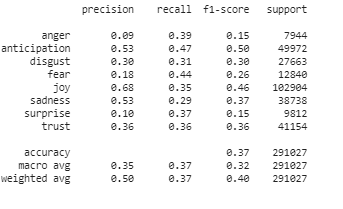

**Training BiLSTM model** \
---

The following are steps on training bidirectional LSTM RNN model :
*  Preparing the dataset to train BiLSTM model
*   Create the function to extract 'text', 'tweet_id', and 'emotion' from each element in the dataset
*  Create a Tokenizer object with a vocabulary size of 500,000 number of words.
*  Use keras pad_sequences to pad the text maximum length of 36 used to represent the text.
*   Create LabelEncoder for emotion labels.
*  Develop the archticture of BiLSTM model to trainand used teh embedding dimension: 500,000 and this one is trainable, Dropout: 0.5, hidden_units 64 per layer * 2 hidden layer, loss: categorical_crossentropy, optimiser: Adam, epoch:5, and batch size: 256.
---
*  The following is the model archticture:

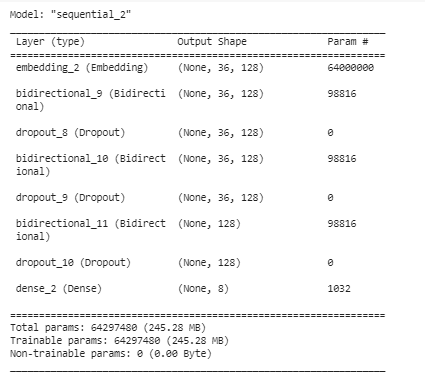


The following classification result shows that the the weighted f1-score of Bi-LSTM model is 0.49 which has a bit improvment on the previous logistic regression.

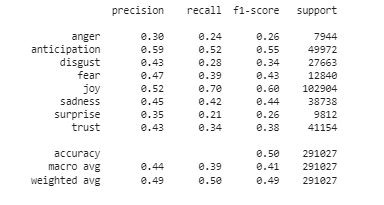


I also tried parameter efficent fine tuning of BERT pre-trained model with LoRA  parameters(i.e r value: 16, lora_alpha :32, lora_dropout :0.2. The trainable parameters are: 891,656 || all params: 125,543,440 || trainable%: 0.71 and the result got the f1-score of 0.45 and 0.47 in different hyperparameters.

#Conclusion

To conclude I have learning some data preprocessing techniques on the twitter emotion recognition dataset. The dataset has class imbalance and I think that affects the traditional machine learning and deep learning model performance.

#========== Import Nececsssary Libraries=========

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install datasets
!pip install torch
!pip install emot
!pip install np_utils

In [3]:
# libraries import
import os
import re
import json
import time
import math
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
%matplotlib inline
sns.set(color_codes=True)
from datasets import Dataset
import datasets
import torch.nn.functional as F

In [4]:
# sklearn library
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import nltk
from nltk.corpus import stopwords

In [5]:
# keras library
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# model
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding
from keras.layers import ReLU, Softmax, Dropout
from keras.callbacks import Callback
from keras.layers import LSTM, Bidirectional
# load model
from keras.models import model_from_json
import nltk
nltk.download('punkt')

#===========Reading the Dataset==================

In [7]:
#Reads a CSV file named "emotion.csv" ,"data_identification.csv", and "sampleSubmission.csv"
emotion_data= pd.read_csv("/content/gdrive/My Drive/Homework/emotion.csv")
data_ident = pd.read_csv("/content/gdrive/My Drive/Homework/data_identification.csv")
sample_subm = pd.read_csv("/content/gdrive/My Drive/Homework/sampleSubmission.csv")

#The code reads a JSON file named "tweets_DM.json" line by line and appends each line to a list named tweets.
tweets = []
for line in open('/content/gdrive/My Drive/Homework/tweets_DM.json', 'r'):
    tweets.append(json.loads(line))

#============Data Preprocessing==================

In [8]:
# Use 'json_normalize' to flatten the JSON data
tweet_norm = pd.json_normalize(tweets)

In [9]:
# Select only the "text" and "tweet_id" columns
tweet_norm = tweet_norm.rename({'_source.tweet.tweet_id': 'tweet_id', '_source.tweet.text': 'text'}, axis='columns')
tweet_norm = tweet_norm[["text", "tweet_id"]]
tweet_norm

,text,tweet_id
0,"People who post ""add me on #Snapchat"" must be ...",0x376b20
1,"@brianklaas As we see, Trump is dangerous to #...",0x2d5350
2,"Confident of your obedience, I write to you, k...",0x28b412
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,0x1cd5b0
4,"""Trust is not the same as faith. A friend is s...",0x2de201
...,...,...
1867530,When you buy the last 2 tickets remaining for ...,0x316b80
1867531,I swear all this hard work gone pay off one da...,0x29d0cb
1867532,@Parcel2Go no card left when I wasn't in so I ...,0x2a6a4f
1867533,"Ah, corporate life, where you can date <LH> us...",0x24faed


In [10]:
# See the emotion data
emotion_data

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [11]:
# See the 'identification.csv' data
data_ident

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [12]:
# Merge data_ident and emotion_data using a left join on 'tweet_id'
merge_ident_emotion = pd.merge(data_ident, emotion_data, how="left", on='tweet_id')
merge_ident_emotion

,tweet_id,identification,emotion
0,0x28cc61,test,NaN
1,0x29e452,train,joy
2,0x2b3819,train,joy
3,0x2db41f,test,NaN
4,0x2a2acc,train,trust
...,...,...,...
1867530,0x227e25,train,disgust
1867531,0x293813,train,sadness
1867532,0x1e1a7e,train,joy
1867533,0x2156a5,train,trust


In [13]:
# Merge tweet_norm and merge_ident_emotion DataFrames using a left join on 'tweet_id'
all_dataset = pd.merge(tweet_norm, merge_ident_emotion, how="left", on='tweet_id')
all_dataset

,text,tweet_id,identification,emotion
0,"People who post ""add me on #Snapchat"" must be ...",0x376b20,train,anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",0x2d5350,train,sadness
2,"Confident of your obedience, I write to you, k...",0x28b412,test,NaN
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,0x1cd5b0,train,fear
4,"""Trust is not the same as faith. A friend is s...",0x2de201,test,NaN
...,...,...,...,...
1867530,When you buy the last 2 tickets remaining for ...,0x316b80,test,NaN
1867531,I swear all this hard work gone pay off one da...,0x29d0cb,test,NaN
1867532,@Parcel2Go no card left when I wasn't in so I ...,0x2a6a4f,test,NaN
1867533,"Ah, corporate life, where you can date <LH> us...",0x24faed,train,joy


In [14]:
# Filter rows where 'identification' is equal to 'train'
train_data = all_dataset[all_dataset["identification"] == "train"]
train_data

,text,tweet_id,identification,emotion
0,"People who post ""add me on #Snapchat"" must be ...",0x376b20,train,anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",0x2d5350,train,sadness
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,0x1cd5b0,train,fear
5,@RISKshow @TheKevinAllison Thx for the BEST TI...,0x1d755c,train,joy
6,Still waiting on those supplies Liscus. <LH>,0x2c91a8,train,anticipation
...,...,...,...,...
1867526,I'm SO HAPPY!!! #NoWonder the name of this sho...,0x321566,train,joy
1867527,In every circumtance I'd like to be thankful t...,0x38959e,train,joy
1867528,there's currently two girls walking around the...,0x2cbca6,train,joy
1867533,"Ah, corporate life, where you can date <LH> us...",0x24faed,train,joy


In [15]:
# Filter rows where 'identification' is equal to 'test'
test_data = all_dataset[all_dataset["identification"] == "test"]
test_data

,text,tweet_id,identification,emotion
2,"Confident of your obedience, I write to you, k...",0x28b412,test,NaN
4,"""Trust is not the same as faith. A friend is s...",0x2de201,test,NaN
9,When do you have enough ? When are you satisfi...,0x218443,test,NaN
30,"God woke you up, now chase the day #GodsPlan #...",0x2939d5,test,NaN
33,"In these tough times, who do YOU turn to as yo...",0x26289a,test,NaN
...,...,...,...,...
1867525,"""For this is the message that ye heard from th...",0x2913b4,test,NaN
1867529,"""There is a lad here, which hath five barley l...",0x2a980e,test,NaN
1867530,When you buy the last 2 tickets remaining for ...,0x316b80,test,NaN
1867531,I swear all this hard work gone pay off one da...,0x29d0cb,test,NaN


In [16]:
#Save DataFrames to CSV Files, here test_data means the public submission data will be used in the end after the model building
train_data.to_csv('/content/gdrive/My Drive/Homework/train_data.csv', index=False)
test_data.to_csv('/content/gdrive/My Drive/Homework/test_data.csv', index=False)

In [17]:
# See emotion distribution over the train_data, and we observe that joy has very high distribution in the data and aslo class imbalance is available
train_data.groupby(['emotion']).count()["tweet_id"]

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: tweet_id, dtype: int64

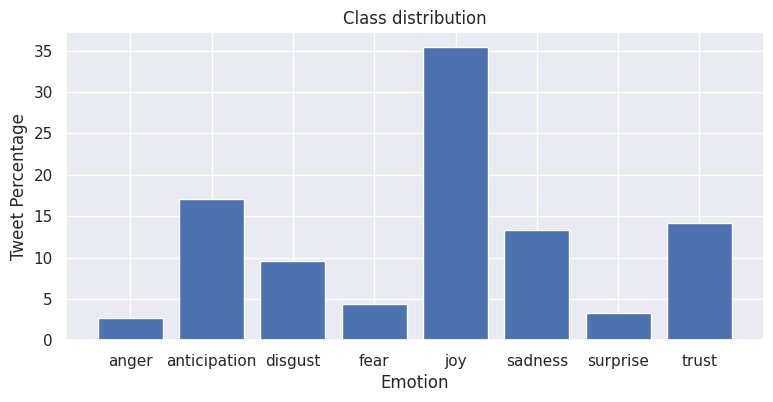

In [18]:
#Ploting Label Distribution Graph
%matplotlib inline
import matplotlib.pyplot as plt
labels = train_data['emotion'].unique()
post_total = len(train_data)
train_data1 = train_data.groupby(['emotion']).count()['tweet_id']
train_data1 = train_data1.apply(lambda x: round(x*100/post_total,3))
fig, ax = plt.subplots(figsize=(9,4))
plt.bar(train_data1.index,train_data1.values)

plt.ylabel('Tweet Percentage')
plt.xlabel('Emotion')
plt.title('Class distribution')
plt.grid(True)
plt.show()

In [19]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# remove hashtags
def hashtags(text):
  hash = re.findall(r"#(\w+)", text)
  return hash


def emoji(text):
  for emot in UNICODE_EMOJI:
    if text == None:
      text = text
    else:
      text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()))
    return text
# remove retweet username and tweeted at @username
def remove_users(tweet):
  tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
  return tweet

# remove links
def remove_links(tweet):
  tweet = re.sub(r'http\S+', '', tweet)
  tweet = re.sub(r'bit.ly/\S+', '', tweet)
  tweet = tweet.strip('[link]')
  return tweet
def clean_html(text):
  html = re.compile('<.*?>')
  return html.sub(r'',text)

# remove non ascii character
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)
def lower(text):
  return text.lower()

# remove stopwords by select english stopwords,add custom words, and remove stop words
def removeStopWords(str):
  stop_words = set(stopwords.words("english"))
  stop_words.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
  new_string = ' '.join([word for word in str.split() if word not in stop_words])
  return new_string

# remove email address
def email_address(text):
  email = re.compile(r'[\w\.-]+@[\w\.-]+')
  return email.sub(r'',text)

def punct(text):
  token=RegexpTokenizer(r'\w+')
  text = token.tokenize(text)
  text= " ".join(text)
  return text

# remove digits and special characters
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

def remove_(tweet):
  tweet = re.sub('([_]+)', "", tweet)
  return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# Apply the previous functions to preprocess
def data_preprocess(dataset, text):
   dataset[text] =dataset[text].apply(func=clean_html)
   dataset[text] =dataset[text].apply(func=remove_digits)
   dataset[text] =dataset[text].apply(func=remove_)
   dataset[text] =dataset[text].apply(func=removeStopWords)
   dataset[text] =dataset[text].apply(func=remove_links)
   dataset[text] =dataset[text].apply(func=remove_special_characters)
   dataset[text] =dataset[text].apply(func=non_ascii)
   dataset[text] =dataset[text].apply(func=email_address)
   dataset[text] =dataset[text].apply(func=punct)
   dataset[text] =dataset[text].apply(func=lower)
   return dataset

In [21]:
# train_data on 'text'column is to preprocess
preprocessed_train = data_preprocess(train_data,'text')

<ipython-input-20-07fce2a2529d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[text] =dataset[text].apply(func=clean_html)
<ipython-input-20-07fce2a2529d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[text] =dataset[text].apply(func=remove_digits)
<ipython-input-20-07fce2a2529d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [22]:
preprocessed_train

,text,tweet_id,identification,emotion
0,people post add snapchat must dehydrated cuz m...,0x376b20,train,anticipation
1,brianklaas as see trump dangerous freepress ar...,0x2d5350,train,sadness
3,now issa stalking tasha,0x1cd5b0,train,fear
5,riskshow thekevinallison thx best time tonight...,0x1d755c,train,joy
6,still waiting supplies liscus,0x2c91a8,train,anticipation
...,...,...,...,...
1867526,i m so happy nowonder name show happy happysyf...,0x321566,train,joy
1867527,in every circumtance i d thankful almighty jes...,0x38959e,train,joy
1867528,there s currently two girls walking around lib...,0x2cbca6,train,joy
1867533,ah corporate life date using relative anachron...,0x24faed,train,joy


In [23]:
preprocessed_train.groupby(['emotion']).count()["tweet_id"]

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: tweet_id, dtype: int64

#=====================Dataset Spliting========================
We split the preprocessed dataset into training and validation dataset with ratio of 80/20.

In [24]:
# Split the preproccessed data  by 20% evaluation (validation), and the remaining 80% for training.
train_dataset, test_dataset = train_test_split(preprocessed_train, test_size=0.20, random_state=42)
train_dataset=train_dataset.dropna()
test_dataset=test_dataset.dropna()

In [25]:
#Read Saved Pickle Files
train_dataset=pd.read_pickle('/content/gdrive/My Drive/Homework/train_dataf.pkl')
test_dataset= pd.read_pickle('/content/gdrive/My Drive/Homework/test_dataf.pkl')

# 1st: Train LogisticRegression Classifier

In [26]:
# build analyzers (bag-of-words)
BOW_100k = CountVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)

# apply analyzer to training data
BOW_100k.fit(train_data['text'])

train_data_BOW_features_100k = BOW_100k.transform(train_dataset['text'])

## check dimension
train_data_BOW_features_100k.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2644440, 1000)

In [27]:
train_data_BOW_features_100k.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
# observe some feature names
feature_names_100k = BOW_100k.get_feature_names_out()
feature_names_100k[100:110]

array(['break', 'breakfast', 'bring', 'bro', 'broke', 'broken', 'brother',
       'brought', 'browns', 'build'], dtype=object)

In [29]:
from sklearn.linear_model import LogisticRegression
X_train = BOW_100k.transform(train_dataset['text'])
y_train = train_dataset['emotion']

X_test = BOW_100k.transform(test_dataset['text'])
y_test = test_dataset['emotion']

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (2644440, 1000)
y_train.shape:  (2644440,)
X_test.shape:  (291027, 1000)
y_test.shape:  (291027,)


In [30]:
## build Logistic Regression model
LR_model = LogisticRegression()

## training!
LR_model = LR_model.fit(X_train, y_train)

## predict!
y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['sadness', 'trust', 'surprise', 'anticipation', 'trust', 'fear',
       'anticipation', 'joy', 'anticipation', 'surprise'], dtype=object)

In [31]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.38
testing accuracy: 0.37


In [32]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.09      0.39      0.15      7944
anticipation       0.53      0.47      0.50     49972
     disgust       0.30      0.31      0.30     27663
        fear       0.18      0.44      0.26     12840
         joy       0.68      0.35      0.46    102904
     sadness       0.53      0.29      0.37     38738
    surprise       0.10      0.37      0.15      9812
       trust       0.36      0.36      0.36     41154

    accuracy                           0.37    291027
   macro avg       0.35      0.37      0.32    291027
weighted avg       0.50      0.37      0.40    291027



#2nd: Train the Bidirectional LSTM

In [33]:
# Preparing the data for use with a machine learning framework or library in dataset format.
train_dataset=Dataset.from_pandas(train_dataset)
test_dataset=Dataset.from_pandas(test_dataset)

In [34]:
train_dataset.shape

(2644440, 4)

In [35]:
test_dataset.shape

(291027, 5)

In [36]:
# Label encoding on train_dataset and test_dataset on 'emotion' column
from sklearn.preprocessing import LabelEncoder
import tensorflow #new line
from keras.utils import to_categorical
import numpy as np
# Fit label encoder on the combined labels of train and test datasets
label_encoder = LabelEncoder()
label_encoder.fit(train_dataset['emotion'])
print('check label: ', label_encoder.classes_)

# Define functions for label encoding and decoding
def label_encode(le, labels):
    enc = le.transform(labels)
    return to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)
# Apply label encoding to train and test emotions
y_train = label_encode(label_encoder, train_dataset['emotion'])
y_test = label_encode(label_encoder, test_dataset['emotion'])

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


In [37]:
# check result
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


y_train.shape:  (2644440, 8)
y_test.shape:  (291027, 8)


In [38]:
(test_dataset)

Dataset({
    features: ['text', 'tweet_id', 'identification', 'emotion', '__index_level_0__'],
    num_rows: 291027
})

In [39]:
train_dataset=train_dataset.remove_columns("identification")
test_dataset=test_dataset.remove_columns("identification")
test_dataset=test_dataset.remove_columns("__index_level_0__")

In [40]:
# Replace them with our actual dataset dictionary
main_dataset= datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
})
main_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tweet_id', 'emotion'],
        num_rows: 2644440
    })
    test: Dataset({
        features: ['text', 'tweet_id', 'emotion'],
        num_rows: 291027
    })
})

In [41]:
train = main_dataset['train']
test = main_dataset['test']

In [42]:
# Create the function to extract 'text', 'tweet_id', and 'emotion' from each element in the dataset
def get_tweet(data):
    tweets, ids, emotions = zip(*((x['text'], x['tweet_id'], x['emotion']) for x in data))
    return  tweets, ids, emotions


In [43]:
# Extract train_tweets, train_ids, train_emotions from the training dataset
train_tweets, train_ids, train_emotions = get_tweet(train)

In [44]:
#Sample data view on index 0
train_tweets[0], train_ids[0],train_emotions[0]

('being spanish european today disgraceful casareal eucommission europarlen catalanreferendum',
 '0x3420f5',
 'disgust')

In [45]:
#Create a Tokenizer object with a vocabulary size of 500,000
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_tweets)

In [46]:
tokenizer.texts_to_sequences([train_tweets[0]]) , train_tweets[0]

([[628, 2427, 5438, 10, 3568, 84508, 6189, 22788, 6653]],
 'being spanish european today disgraceful casareal eucommission europarlen catalanreferendum')

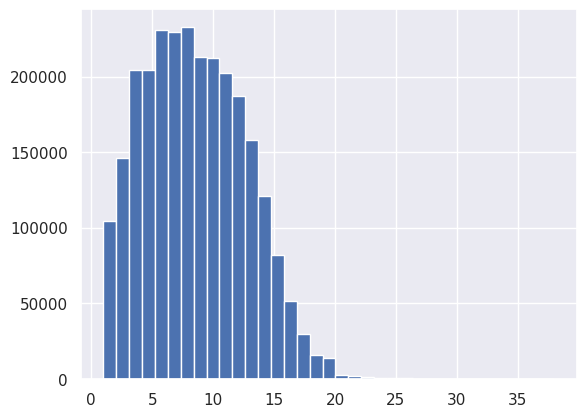

In [47]:
# Plot histogram to see the distribution of tweet lengths in the training dataset
lengths = [len(t.split(' ')) for t in train_tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [48]:
maxlen = 36  # The desired maximum sequence length is set 36
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_padded_sequences(tokenizer, tweets, maxlen=None):
    sequences = tokenizer.texts_to_sequences(tweets)   # Convert text sequences to numerical sequences
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)    # Pad sequences with zeros, truncating or padding as needed
    return padded_sequences

In [49]:
train_padded_sequences = get_padded_sequences(tokenizer, train_tweets, maxlen=maxlen)

In [50]:
classes = set(train_emotions)
print(classes)

{'trust', 'disgust', 'joy', 'sadness', 'anger', 'surprise', 'fear', 'anticipation'}


In [52]:
train_labels = y_train

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Vocabulary size for the Embedding layer aligned with the previous tokenizer number of words
vocabulary_size = min(len(tokenizer.word_index) + 1, 500000)
# Define the model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocabulary_size , output_dim=128, input_length=maxlen))

# Bidirectional LSTM layer with dropout to prevent overfitting
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))

# Bidirectional LSTM layer with dropout
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))

# Output layer with softmax activation for multilabel classification
model.add(Dense(units=8, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 36, 128)           64000000  
                                                                 
 bidirectional_9 (Bidirecti  (None, 36, 128)           98816     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 36, 128)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 36, 128)           98816     
 ional)                                                          
                                                                 
 dropout_9 (Dropout)         (None, 36, 128)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128)              

In [65]:
test_tweets , test_id, test_emotions = get_tweet(test)
test_padded_sequences = get_padded_sequences(tokenizer, test_tweets)
test_labels = y_test

In [66]:
train_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [67]:
test_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [68]:
import tensorflow as tf
import numpy as np

csv_logger = tf.keras.callbacks.CSVLogger('./training_log.csv')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model with early stopping and class weights
history = model.fit(
    train_padded_sequences, train_labels,
    validation_data=(test_padded_sequences, test_labels),
    epochs=5,
    batch_size=256,
    callbacks=[csv_logger, early_stopping_callback],
)

print('Training is finished')


Epoch 1/5
10330/10330 [==============================] - 350s 33ms/step - loss: 0.9542 - accuracy: 0.6734 - val_loss: 1.6168 - val_accuracy: 0.4890
Epoch 2/5
10330/10330 [==============================] - 320s 31ms/step - loss: 0.4999 - accuracy: 0.8318 - val_loss: 1.8868 - val_accuracy: 0.4929
Epoch 3/5
10330/10330 [==============================] - 317s 31ms/step - loss: 0.3644 - accuracy: 0.8759 - val_loss: 2.0579 - val_accuracy: 0.4969
Epoch 4/5
10330/10330 [==============================] - 317s 31ms/step - loss: 0.2893 - accuracy: 0.9003 - val_loss: 2.2084 - val_accuracy: 0.5033
Epoch 5/5
10330/10330 [==============================] - 318s 31ms/step - loss: 0.2395 - accuracy: 0.9172 - val_loss: 2.4002 - val_accuracy: 0.4974
Training is finished


In [69]:
import pandas as pd
history_log = pd.DataFrame()
history_log = pd.read_csv("./training_log.csv")
history_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.673385,0.954231,0.488962,1.616805
1,1,0.831773,0.499875,0.492868,1.886763
2,2,0.875862,0.364359,0.496902,2.057890
3,3,0.900290,0.289296,0.503259,2.208449
4,4,0.917211,0.239456,0.497435,2.400178


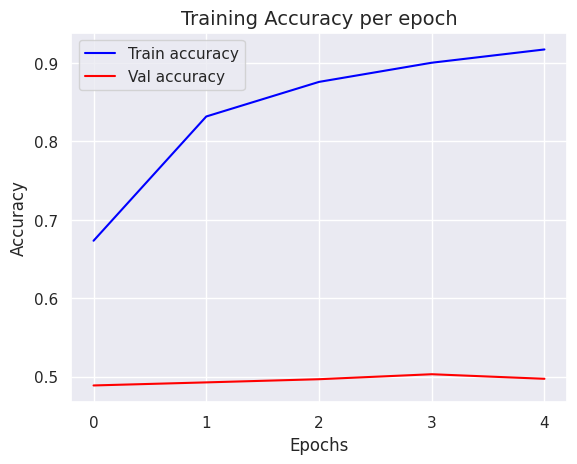

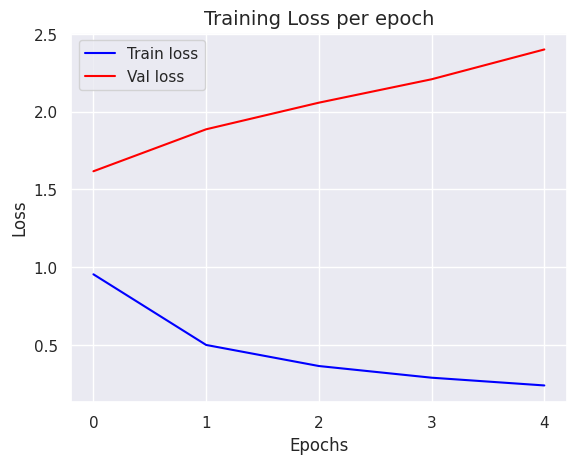

In [70]:
# Check how the model is learning and know when to stop training to avoid overfitting
df = history_log

plt.plot(df['accuracy'], color='blue', label='Train accuracy')
plt.plot(df['val_accuracy'], color='red', label='Val accuracy')
plt.title('Training Accuracy per epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(0, len(df['accuracy']), step=1))  # Set integer values for x-axis ticks
plt.legend()
plt.show()

# Training Loss per epoch
plt.plot(df['loss'], color='blue', label='Train loss')
plt.plot(df['val_loss'], color='red', label='Val loss')
plt.title('Training Loss per epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(np.arange(0, len(df['loss']), step=1))  # Set integer values for x-axis ticks
plt.legend()
plt.show()

In [71]:
#Prediction on the testdata
prediction_result = model.predict(test_padded_sequences, batch_size=128)

2274/2274 [==============================] - 15s 6ms/step


In [72]:
from sklearn.metrics import accuracy_score
prediction_result = label_decode(label_encoder, prediction_result)
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), prediction_result), 2)))

testing accuracy: 0.5


In [73]:
# Classification report on the test data
from sklearn.metrics import classification_report
print(classification_report(label_decode(label_encoder, y_test), prediction_result))

              precision    recall  f1-score   support

       anger       0.30      0.24      0.26      7944
anticipation       0.59      0.52      0.55     49972
     disgust       0.43      0.28      0.34     27663
        fear       0.47      0.39      0.43     12840
         joy       0.52      0.70      0.60    102904
     sadness       0.45      0.42      0.44     38738
    surprise       0.35      0.21      0.26      9812
       trust       0.43      0.34      0.38     41154

    accuracy                           0.50    291027
   macro avg       0.44      0.39      0.41    291027
weighted avg       0.49      0.50      0.49    291027



#===Testing the model to prediction of  sampleSubmission daata=============

In [74]:
#data preparations for predcition of samplesubmission 'text' column
X_private_test = tokenizer.texts_to_sequences(test_data['text'])
X_private_test = pad_sequences(X_private_test, maxlen=maxlen, padding='post')
print('Shape of data tensor:', X_private_test.shape)

Shape of data tensor: (411972, 36)


In [75]:
##Prediction on the the public submission dataset
test_result = model.predict(X_private_test, batch_size=128)
test_result = label_decode(label_encoder, test_result)

3219/3219 [==============================] - 19s 6ms/step


In [76]:
test_result[:3]

array(['anticipation', 'anticipation', 'anticipation'], dtype='<U12')

In [77]:
test_data["emotion"] = test_result

<ipython-input-77-702ca7d83a62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["emotion"] = test_result


In [78]:
# See the prediction dataframe on 'emotion' column by the model
test_data

,text,tweet_id,identification,emotion
2,"Confident of your obedience, I write to you, k...",0x28b412,test,anticipation
4,"""Trust is not the same as faith. A friend is s...",0x2de201,test,anticipation
9,When do you have enough ? When are you satisfi...,0x218443,test,anticipation
30,"God woke you up, now chase the day #GodsPlan #...",0x2939d5,test,trust
33,"In these tough times, who do YOU turn to as yo...",0x26289a,test,trust
...,...,...,...,...
1867525,"""For this is the message that ye heard from th...",0x2913b4,test,joy
1867529,"""There is a lad here, which hath five barley l...",0x2a980e,test,anticipation
1867530,When you buy the last 2 tickets remaining for ...,0x316b80,test,joy
1867531,I swear all this hard work gone pay off one da...,0x29d0cb,test,joy


In [79]:
# Store the prediction result pnly with two columns 'tweet_id' and 'emotion'
test_result = test_data[["tweet_id", "emotion"]]

In [80]:
# Rename 'tweet_id' column to 'id' on the public submission data
test_result = test_result.rename({'tweet_id': 'id'}, axis='columns')

In [81]:
#Save the result to local folder for subimission
test_result.to_csv("/content/gdrive/My Drive/Homework/submissiong.csv", index=False)